In [1]:
import statsmodels.api as sm
import scipy
from scipy import power
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import TTestPower
import pandas as pd
import numpy as np
import random
from statsmodels.stats.proportion import proportion_effectsize
import matplotlib.pyplot as plt
import math

## Допустим у нас есть таблица по пользовательским платам и мы решили протестировать новую фичу, которая предположительно поднимет пользовательскую плату в среднем на 0.3 единицы валюты 

In [2]:
userpay_data = pd.DataFrame(columns = ['user_id', 'payment'])
userpay_data['user_id'] = np.arange(1, 5001)
arr = []
for i in range(5000):
    x = random.gauss(13, 2.3)
    arr.append(x)
userpay_data['payment'] = np.array(arr)

In [3]:
userpay_data

,user_id,payment
0,1,11.314598
1,2,10.940915
2,3,15.823827
3,4,11.246462
4,5,14.977500
...,...,...
4995,4996,10.668202
4996,4997,11.564437
4997,4998,10.059794
4998,4999,12.489653


<Axes: >

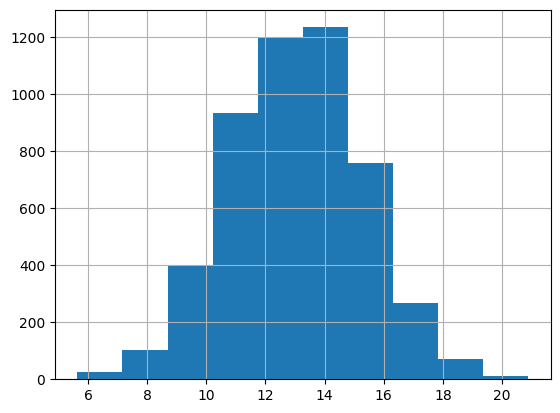

In [4]:
userpay_data['payment'].hist()

In [5]:
userpay_data['payment'].mean()

13.032290918980772

# Итак, нам понадобится >= 924 наблюдений, возьмем 1000

In [6]:
TTestIndPower().solve_power(alpha = 0.05, power = 0.8, effect_size = (13.3 - 13)/2.3, alternative = 'two-sided')

923.638516763391

## Разобьем пользователей на  тестовую и контрольную группы

In [7]:
userpay_data['group'] = random.choices(['Test', 'Controll'], weights = [50, 50], k = 5000)
userpay_data

,user_id,payment,group
0,1,11.314598,Controll
1,2,10.940915,Controll
2,3,15.823827,Controll
3,4,11.246462,Controll
4,5,14.977500,Controll
...,...,...,...
4995,4996,10.668202,Test
4996,4997,11.564437,Controll
4997,4998,10.059794,Controll
4998,4999,12.489653,Test


In [8]:
df_test = userpay_data[userpay_data['group'] == 'Test'].sample(1000)
df_controll = userpay_data[userpay_data['group'] == 'Controll'].sample(1000)

### Наша контрольная группа 

In [9]:
arr1 = []
for i in range(1000):
    x = random.gauss(13, 2.3)
    arr1.append(x)
df_controll['payment'] = np.array(arr1)

### Наша тестовая группа

In [10]:
arr2 = []
for i in range(1000):
    x = random.gauss(13.31, 2.3)
    arr2.append(x)
df_test['payment'] = np.array(arr2)

<Axes: >

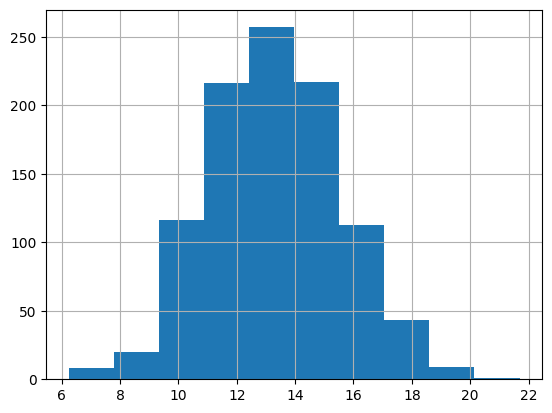

In [11]:
df_test['payment'].hist()

In [12]:
t_score, p_value, dgf = sm.stats.ttest_ind(df_test['payment'], df_controll['payment'])
print(t_score, '{:.12f}'.format(p_value), dgf)

4.614939715517205 0.000004181787 1998.0


In [13]:
if p_value > 0.05:
    print('T-ТЕСТ ПОКАЗАЛ , ЧТО Р-VALUE > 0.05, А ЗНАЧИТ МЫ ОТКЛОНЯЕМ АЛЬТЕРНАТИВНУЮ ГЕПОТЕЗУ В ПОЛЬЗУ НУЛЕВОЙ')
else:
    print('Т-тест показал p-value меньше 0.05 а значит мы можем отвергнуть нулевую гепотезу(фича не сработала и средние выборок равны) в пользу альтернативной(фича сработала и средние выборок значимо различаются)на уровне статистической значимости в 0.95')

Т-тест показал p-value меньше 0.05 а значит мы можем отвергнуть нулевую гепотезу(фича не сработала и средние выборок равны) в пользу альтернативной(фича сработала и средние выборок значимо различаются)на уровне статистической значимости в 0.95


## В случае если фича сработает в обратном направлении(уменьшит среднюю плату) т-значение станет отрицательным и мы получим сигнал о том, что фичу лучше не вводить

In [14]:
arr3 = []
for i in range(1000):
    x = random.gauss(12.69, 2.3)
    arr3.append(x)
df_test['payment2'] = np.array(arr3)

In [15]:
t_score, p_value, dgf = sm.stats.ttest_ind(df_test['payment2'], df_controll['payment'])
print(t_score, '{:.12f}'.format(p_value), dgf)

-2.2239342480983804 0.026264268964 1998.0


# Следущий тест будет также на равенство, но с использованием стратификации

### Датафрейм будет содержать идентификатор пользователя, информацию о покупке и страту, к которой пользователь принадлежит;
### каждая страта будет отличаться по средней плате на пользователя и количеству пользователей

In [16]:
a, b, c = pd.DataFrame(columns = ['uid', 'payment', 'strat']), pd.DataFrame(columns = ['uid', 'payment', 'strat']), pd.DataFrame(columns = ['uid', 'payment', 'strat'])
a['uid'], a['payment'], a['strat'] = np.arange(1000), np.random.normal(21, 2.2, 1000), 'blue'
b['uid'], b['payment'], b['strat'] = np.arange(1000, 3700), np.random.normal(45, 2.2, 2700), 'green'
c['uid'], c['payment'], c['strat'] = np.arange(3700, 7200), np.random.normal(34, 2.2, 3500), 'red'

user_sales = pd.concat([a,b,c], axis = 0)

In [17]:
user_sales

,uid,payment,strat
0,0,23.625454,blue
1,1,20.335963,blue
2,2,21.847216,blue
3,3,21.796455,blue
4,4,21.644981,blue
...,...,...,...
3495,7195,33.417844,red
3496,7196,33.801935,red
3497,7197,33.697952,red
3498,7198,35.243415,red


In [18]:
user_sales['payment'].std()

8.250055710964306

### Вычислим размер групп

In [19]:
group_size = math.ceil(TTestIndPower().solve_power(alpha = 0.05, power = 0.8, effect_size = (0.7/user_sales['payment'].std()), alternative = 'two-sided')
)
group_size

2182

### Разобьем пользователей на группы

In [20]:
user_sales['group'] = random.choices(['test', 'control'], weights = [50, 50], k = 7200)
user_sales

,uid,payment,strat,group
0,0,23.625454,blue,test
1,1,20.335963,blue,control
2,2,21.847216,blue,control
3,3,21.796455,blue,test
4,4,21.644981,blue,control
...,...,...,...,...
3495,7195,33.417844,red,test
3496,7196,33.801935,red,control
3497,7197,33.697952,red,control
3498,7198,35.243415,red,control


### Отдельно выпишем веса страт и их размеры внутри групп

In [21]:
weights = user_sales.groupby('strat')['payment'].count()/len(user_sales)
weights

strat
blue     0.138889
green    0.375000
red      0.486111
Name: payment, dtype: float64

In [22]:
strat_sizes = pd.Series({'blue':math.ceil(weights[0]*group_size),
                         'green':math.ceil(weights[1]*group_size),
                         'red':math.ceil(weights[2]*group_size)})
strat_sizes

C:\Users\cours\AppData\Local\Temp\ipykernel_13740\1264020507.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strat_sizes = pd.Series({'blue':math.ceil(weights[0]*group_size),
C:\Users\cours\AppData\Local\Temp\ipykernel_13740\1264020507.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'green':math.ceil(weights[1]*group_size),
C:\Users\cours\AppData\Local\Temp\ipykernel_13740\1264020507.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

blue      304
green     819
red      1061
dtype: int64

### Проведем стратифицированное сэмплирование

In [23]:
user_sales_control = pd.concat([user_sales.query("group == 'control' & strat == 'blue'").sample(strat_sizes['blue']),
                               user_sales.query("group == 'control' & strat == 'green'").sample(strat_sizes['green']),
                               user_sales.query("group == 'control' & strat == 'red'").sample(strat_sizes['red'])], axis = 0)

user_sales_test = pd.concat([user_sales.query("group == 'test' & strat == 'blue'").sample(strat_sizes['blue']),
                               user_sales.query("group == 'test' & strat == 'green'").sample(strat_sizes['green']),
                               user_sales.query("group == 'test' & strat == 'red'").sample(strat_sizes['red'])], axis = 0)                           

### Благодаря стратификации чувствительность теста должна была вырасти, поэтому имитируем увеличение средней платы не на 0.7,
### а на 0.4 и посмотрим задетектирует ли он эффект меньше заложенного изначально

In [24]:
user_sales_test['payment'] = user_sales_test['payment'] + 0.4

### Расчитаем стратифицированное среднее и стратифицированную дисперсию в каждой группе

In [25]:
strat_mean_control = sum(user_sales_control.groupby('strat')['payment'].mean()*weights)
strat_mean_test = sum(user_sales_test.groupby('strat')['payment'].mean()*weights)
strat_var_control = sum(user_sales_control.groupby('strat')['payment'].var()*weights)
strat_var_test = sum(user_sales_test.groupby('strat')['payment'].var()*weights)
(strat_mean_control, strat_mean_test) , (strat_var_control, strat_var_test)

((36.26476577023365, 36.67615384987815),
 (4.954825058498466, 4.829955677864438))

In [26]:
tscore = (strat_mean_test - strat_mean_control)/(strat_var_control/len(user_sales_control) + strat_var_test/len(user_sales_test))**0.5

In [27]:
pval = 2*(1 - scipy.stats.norm.cdf(np.abs(tscore)))

In [28]:
if pval < 0.05:
    print('p-значение меньше альфа, значит с вероятностью 95%  распределения метрики в группах статистически различаются', tscore, '{:.12f}'.format(pval))
else:
    print('Различие между группами статистически не значимо на уровне 95% ')

p-значение меньше альфа, значит с вероятностью 95%  распределения метрики в группах статистически различаются 6.146140322239678 0.000000000794


# Проведем еще один тест, но на конверсию

In [29]:
user_conversion = pd.DataFrame(columns = ['user_id', 'action'])
user_conversion['user_id'] = np.arange(3000)
user_conversion['action'] = np.array(random.choices([0,1], weights = [90, 10], k = 3000))

In [30]:
proportion_effectsize(0.14, 0.1)

0.1234928990685823

# Возьмем 1040 наблюдений

In [31]:
TTestIndPower().solve_power(alpha = 0.05, power = 0.8, effect_size = 0.1234928990685823, alternative = 'two-sided')

1030.2865281274026

# Определим группы для пользователей

In [32]:
user_conversion['group'] = random.choices(['Test', 'Controll'], weights = [50,50], k = 3000)

In [33]:
conv_test = user_conversion[user_conversion['group'] == 'Test'].sample(1040)
conv_controll = user_conversion[user_conversion['group'] == 'Controll'].sample(1040)

## Получаем новые данные

In [34]:
conv_controll['action'] = np.array(random.choices([0,1], weights = [90, 10], k = 1040))
conv_test['action'] = np.array(random.choices([0,1], weights = [86.3, 14.7], k = 1040))

## Проводим т-тест 

In [35]:
t, pvalue, dgfr = sm.stats.ttest_ind(conv_test['action'],conv_controll['action'])
t, pvalue, dgfr

(4.3479116211728, 1.4407980802197083e-05, 2078.0)

## Проведя z-тест для пропорций получим примерно такие же результаты

In [36]:
sm.stats.proportions_ztest([conv_test[conv_test['action'] == 1]['action'].count(), 
                            conv_controll[conv_controll['action'] == 1]['action'].count()],
                            [conv_test['action'].count(), conv_controll['action'].count()])

(4.330350666230168, 1.488720775145906e-05)

In [37]:
if pvalue < 0.05:
    print('Итак мы получили статистически значимые различия и можем отвергнуть нулевую гепотезу в пользу альтернативной со статистической значимостью 0.95, t-значение сдвинулось вправо - то есть среднее в распределении увеличилось по сравнению с первоначальным, а значит количество единиц выросло')
else:
    print('P-VALUE> 0.05 А ЗНАЧИТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ НЕ БЫЛО ОБНАРУЖЕНО И ВОЗМОЖНОСТИ ОТВЕРГНУТЬ НУЛЕВУЮ ГЕПОТЕЗУ НЕТ')

Итак мы получили статистически значимые различия и можем отвергнуть нулевую гепотезу в пользу альтернативной со статистической значимостью 0.95, t-значение сдвинулось вправо - то есть среднее в распределении увеличилось по сравнению с первоначальным, а значит количество единиц выросло


# Проведем последний тест на равенство медиан с использованием Bootstrap

## Сгенерируем массив, состоящий из случайных 60 чисел от 1 до 10

In [38]:
sample = np.random.randint(1, 10, 60)

In [39]:
sample

array([8, 6, 7, 8, 8, 7, 5, 3, 4, 4, 5, 9, 8, 3, 4, 9, 2, 2, 3, 8, 9, 8,
       2, 3, 4, 4, 5, 3, 4, 7, 3, 5, 8, 7, 3, 3, 1, 2, 4, 9, 6, 9, 3, 7,
       1, 1, 5, 4, 3, 5, 3, 2, 4, 5, 1, 3, 1, 1, 5, 5])

## Напишем функцию для бутстрапирования и применим к раннее созданному массиву

In [40]:
def getbootstrap(arr, N):
    n = arr.size
    boot = np.random.choice(arr, size = (n, N), replace = True)
    return boot

In [41]:
boot_sample = getbootstrap(sample, 15000)

In [42]:
boot_sample

array([[2, 9, 3, ..., 3, 3, 2],
       [9, 4, 7, ..., 5, 9, 7],
       [8, 3, 8, ..., 3, 8, 5],
       ...,
       [7, 1, 3, ..., 7, 1, 2],
       [9, 2, 4, ..., 3, 3, 3],
       [6, 3, 3, ..., 5, 2, 3]])

## Найдем распределение медианы в бутстрап-сэмпле

In [43]:
boot_sample_median = np.median(boot_sample, axis = 0)

(array([3.630e+02, 2.990e+02, 9.130e+03, 0.000e+00, 1.364e+03, 3.810e+03,
        0.000e+00, 2.200e+01, 1.100e+01, 1.000e+00]),
 array([3.  , 3.35, 3.7 , 4.05, 4.4 , 4.75, 5.1 , 5.45, 5.8 , 6.15, 6.5 ]),
 <BarContainer object of 10 artists>)

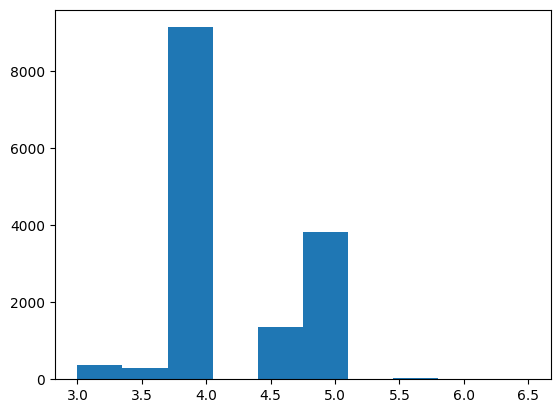

In [44]:
plt.hist(boot_sample_median)

## Напишем еще одну функцию для вычисления 95%-го доверительного интервала интервала и применим ее к выборке медиан

In [45]:
def confidence_interval(array):
    left = np.quantile(array, 0.05/2)
    right = np.quantile(array, 1 - 0.05/2)
    return left, right

In [46]:
print('95% значений медианы лежат в интервале', {confidence_interval(boot_sample_median)})

95% значений медианы лежат в интервале {(3.5, 5.0)}


## Создадим еще один сэмпл, применим к нему функцию для бутстрапа и затем найдем распределение медиан и 95%-й доверительный интервал для этого распределения

In [47]:
sample2 = np.random.randint(100, 150, 60)

In [48]:
boot_sample2 = getbootstrap(sample2, 15000)

In [49]:
boot_sample2_median = np.median(boot_sample2, axis = 0)
boot_sample2_median

array([122. , 125.5, 123. , ..., 130. , 124. , 118. ])

In [50]:
print('У этого распределения 95% всех начений медианы лежат между', {confidence_interval(boot_sample2_median)})


У этого распределения 95% всех начений медианы лежат между {(118.0, 132.5)}


## Теперь найдем 95%-й доверительный интервал для разностей медиан этих двух распределений

In [51]:
confidence_interval(boot_sample2_median - boot_sample_median)

(113.5, 128.5)

## Нуль не входит в этот интервал а значит медианы этих распределений с 95% вероятностью не равны

(array([2.970e+02, 7.270e+02, 3.283e+03, 5.496e+03, 2.681e+03, 1.390e+03,
        4.100e+02, 4.460e+02, 2.660e+02, 4.000e+00]),
 array([111. , 113.2, 115.4, 117.6, 119.8, 122. , 124.2, 126.4, 128.6,
        130.8, 133. ]),
 <BarContainer object of 10 artists>)

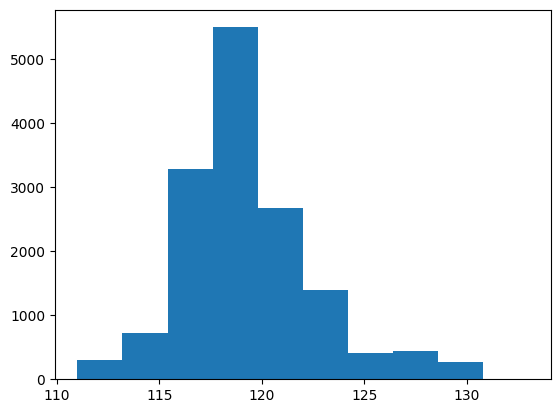

In [52]:
plt.hist(boot_sample2_median - boot_sample_median)

((array([3.630e+02, 2.990e+02, 9.130e+03, 0.000e+00, 1.364e+03, 3.810e+03,
         0.000e+00, 2.200e+01, 1.100e+01, 1.000e+00]),
  array([3.  , 3.35, 3.7 , 4.05, 4.4 , 4.75, 5.1 , 5.45, 5.8 , 6.15, 6.5 ]),
  <BarContainer object of 10 artists>),
 (array([6.480e+02, 6.600e+02, 5.457e+03, 3.384e+03, 3.040e+03, 6.740e+02,
         4.770e+02, 2.870e+02, 3.690e+02, 4.000e+00]),
  array([116. , 118.1, 120.2, 122.3, 124.4, 126.5, 128.6, 130.7, 132.8,
         134.9, 137. ]),
  <BarContainer object of 10 artists>))

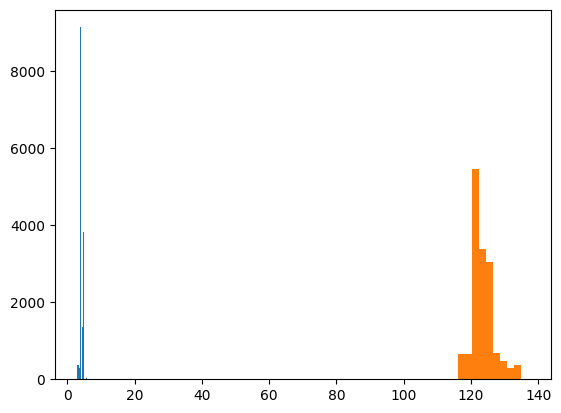

In [53]:
plt.hist(boot_sample_median), plt.hist(boot_sample2_median)